In [145]:
# Базовые библиотеки: численные массивы + графики
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import joblib

# Разбиение на train/test и метрики качества
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

# Модель дерева + визуализация структуры и экспорт правил
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# “Быстрая интерпретация”: важность признаков через перемешивание (permutation importance)
from sklearn.inspection import permutation_importance

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [133]:
# функция подсчета и вывода метрик(f1, acc, roc-auc, confusion matrix)
def print_metrics(y_true, y_pred, y_proba=None, title=None):
    # y_true, y_pred: истинные и предсказанные метки классов (например, 0/1)
    # y_proba: вероятность класса 1 (нужна, если хотим посчитать ROC-AUC)
    if title:
        print(title)
    # Accuracy – доля правильных ответов (хороша как “первая” метрика, но не всегда достаточно)
    acc = accuracy_score(y_true, y_pred)
    # F1 – баланс precision/recall (часто полезнее accuracy при дисбалансе классов)
    f1 = f1_score(y_true, y_pred)
    print(f"accuracy = {acc:.4f}")
    print(f"f1       = {f1:.4f}")
    if y_proba is not None:
        # ROC-AUC корректно считать по вероятностям/скорингам, а не по “жёстким” классам
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"roc_auc  = {auc:.4f}")
        except Exception:
            # Иногда AUC может не считаться (например, если в y_true один класс)
            pass
    print("confusion_matrix:")
    print(confusion_matrix(y_true, y_pred))
    print()

In [80]:
df = pd.read_csv("S06-hw-dataset-02.csv")
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [82]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


In [83]:
# определяем признаки X и таргеты y
X = df.loc[:, "f01":"x_int_2"]
y = df["target"]

# Train/Test-сплит и воспроизводимость
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [84]:
baseline_dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
baseline_dummy.fit(X_train, y_train)

baseline_logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])
baseline_logreg.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('logreg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not w

In [85]:
#metrics baseline_dummy
print_metrics(y_test, baseline_dummy.predict(X_test), baseline_dummy.predict_proba(X_test)[:, 1], "baseline_dummy")

baseline_dummy
accuracy = 0.7375
f1       = 0.0000
roc_auc  = 0.5000
confusion_matrix:
[[2655    0]
 [ 945    0]]



In [86]:
#metrics baseline_logreg
print_metrics(y_test, baseline_logreg.predict(X_test), baseline_logreg.predict_proba(X_test)[:, 1], "baseline_logreg")

baseline_logreg
accuracy = 0.8119
f1       = 0.5607
roc_auc  = 0.7977
confusion_matrix:
[[2491  164]
 [ 513  432]]



In [154]:
#пункт 2.3.4

# tree_full = DecisionTreeClassifier(random_state=RANDOM_STATE)
# tree_full.fit(X_train, y_train)
# # Сравним качество на train и test – это базовый способ “поймать” переобучение.
# y_pred_train = tree_full.predict(X_train)
# y_pred_test = tree_full.predict(X_test)
# print_metrics(y_train, y_pred_train, title="FULL TREE – train")
# print_metrics(y_test, y_pred_test, title="FULL TREE – test")

# dec_tree = DecisionTreeClassifier(
#     max_depth=5,
#     min_samples_leaf=10,
#     random_state=RANDOM_STATE
# )
# dec_tree.fit(X_train, y_train)

# print_metrics(y_train, dec_tree.predict(X_train), dec_tree.predict_proba(X_train)[:, 1], title="REGULARIZED TREE – train")
# print_metrics(y_test, dec_tree.predict(X_test), dec_tree.predict_proba(X_test)[:, 1], title="REGULARIZED TREE – test")

param_grid = {
    "max_depth": [1, 5],
    "min_samples_leaf": [1, 5],
}
dec_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

grid_dec_tree = GridSearchCV(
    dec_tree,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
)

grid_dec_tree.fit(X_train, y_train)
print(grid_dec_tree.best_params_)
dec_tree_best = grid_dec_tree.best_estimator_
print_metrics(y_test, dec_tree_best.predict(X_test), dec_tree_best.predict_proba(X_test)[:, 1], title="dec_tree – test")

{'max_depth': 5, 'min_samples_leaf': 5}
dec_tree – test
accuracy = 0.7922
f1       = 0.4228
roc_auc  = 0.7908
confusion_matrix:
[[2578   77]
 [ 671  274]]



In [155]:
rand_forest = RandomForestClassifier(random_state=RANDOM_STATE)
grid_rand_forest = GridSearchCV(
    rand_forest,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
)
grid_rand_forest.fit(X_train, y_train)
print(grid_rand_forest.best_params_)
rand_forest_best = grid_rand_forest.best_estimator_
print_metrics(y_test, rand_forest_best.predict(X_test), rand_forest_best.predict_proba(X_test)[:, 1], title="rand_forest – test")

{'max_depth': 5, 'min_samples_leaf': 5}
rand_forest – test
accuracy = 0.8072
f1       = 0.4466
roc_auc  = 0.8615
confusion_matrix:
[[2626   29]
 [ 665  280]]



In [156]:
grad_boosting = GradientBoostingClassifier(random_state=RANDOM_STATE)
grid_grad_boosting = GridSearchCV(
    grad_boosting,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
)
grid_grad_boosting.fit(X_train, y_train)
print(grid_grad_boosting.best_params_)
grad_boosting_best = grid_grad_boosting.best_estimator_
print_metrics(y_test, grad_boosting_best.predict(X_test), grad_boosting_best.predict_proba(X_test)[:, 1], title="grad_boosting – test")

{'max_depth': 5, 'min_samples_leaf': 5}
grad_boosting – test
accuracy = 0.8983
f1       = 0.7855
roc_auc  = 0.9246
confusion_matrix:
[[2564   91]
 [ 275  670]]



In [157]:
models_metrics = pd.DataFrame({
    "decision_tree": {
        "accuracy": accuracy_score(y_test, dec_tree_best.predict(X_test)),
        "f1": f1_score(y_test, dec_tree_best.predict(X_test)),
        "roc-auc": roc_auc_score(y_test, dec_tree_best.predict_proba(X_test)[:, 1])
    },
                 
    "random_forest": {
        "accuracy": accuracy_score(y_test, rand_forest_best.predict(X_test)),
        "f1": f1_score(y_test, rand_forest_best.predict(X_test)),
        "roc-auc": roc_auc_score(y_test, rand_forest_best.predict_proba(X_test)[:, 1])
    },
    
    "gradient_boosting": {
        "accuracy": accuracy_score(y_test, grad_boosting_best.predict(X_test)),
        "f1": f1_score(y_test, grad_boosting_best.predict(X_test)),
        "roc-auc": roc_auc_score(y_test, grad_boosting_best.predict_proba(X_test)[:, 1])
    },
})

models_metrics

,decision_tree,random_forest,gradient_boosting
accuracy,0.792222,0.807222,0.898333
f1,0.422840,0.446571,0.785463
roc-auc,0.790812,0.861525,0.924640


***Лучшей моделью по ROC-AUC критерию оказалась модель GradientBoostingClassifier***

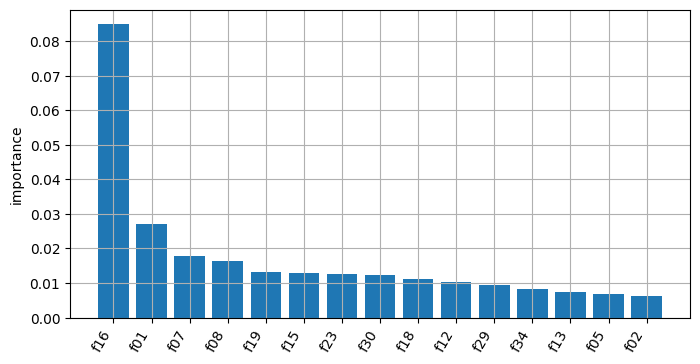

In [158]:
perm = permutation_importance(
    grad_boosting_best, X_test, y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)
importances = perm.importances_mean
idx = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), [X_test.columns[i] for i in idx], rotation=60, ha="right")
plt.ylabel("importance")

plt.grid()
plt.savefig("artifacts/figures/importancees.png")
plt.show()

Топ 5 важных признаков оказались f16, f01, f07, f08, f19

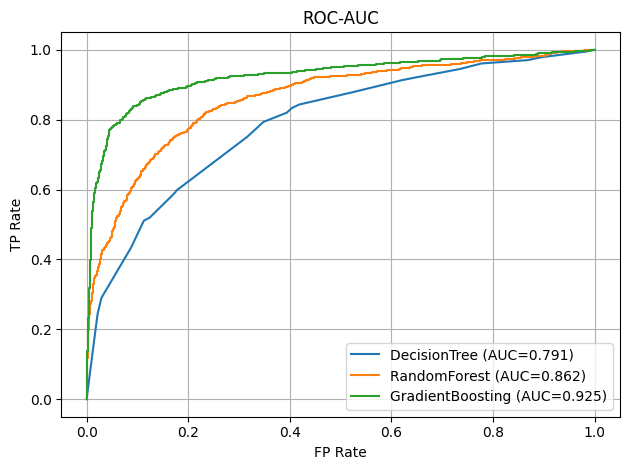

In [159]:
models = {
    "DecisionTree": dec_tree_best,
    "RandomForest": rand_forest_best, 
    "GradientBoosting": grad_boosting_best
}
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC-AUC")
plt.legend()

plt.grid()
plt.tight_layout()
plt.savefig("artifacts/figures/roc-auc.png")
plt.show()

**Устойчивать на STATE** 

In [175]:
States = [42, 10, 100, 72, 200]
results_dec_tree = {}
results_random_forest = {}
for state in States:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=state, stratify=y
    )
    dec_tree = DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=5,
        random_state=state, 
    )
    dec_tree.fit(X_train, y_train)
    results_dec_tree[state] = {
        "accuracy": accuracy_score(y_test, dec_tree.predict(X_test)),
        "f1": f1_score(y_test, dec_tree.predict(X_test)),
        "roc-auc": roc_auc_score(y_test, dec_tree.predict_proba(X_test)[:, 1])
    }

    rand_forest = RandomForestClassifier(
        max_depth=5,
        min_samples_leaf=5,
        random_state=state, 
    )
    rand_forest.fit(X_train, y_train)
    results_random_forest[state] = {
        "accuracy": accuracy_score(y_test, rand_forest.predict(X_test)),
        "f1": f1_score(y_test, rand_forest.predict(X_test)),
        "roc-auc": roc_auc_score(y_test, rand_forest.predict_proba(X_test)[:, 1])
    }
    
df_results_dec_tree = pd.DataFrame(results_dec_tree).T
df_results_dec_tree['f1-std'] = df_results_dec_tree['f1'].std()
df_results_dec_tree['roc-auc-std'] = df_results_dec_tree['roc-auc'].std()
print("DecisionTree\n", df_results_dec_tree)

df_results_rand_forest = pd.DataFrame(results_random_forest).T
df_results_rand_forest['f1-std'] = df_results_rand_forest['f1'].std()
df_results_rand_forest['roc-auc-std'] = df_results_rand_forest['roc-auc'].std()
print("\nRandomForest\n", df_results_rand_forest)

DecisionTree
      accuracy        f1   roc-auc    f1-std  roc-auc-std
42   0.792222  0.422840  0.790812  0.060652     0.005237
10   0.789722  0.574001  0.795320  0.060652     0.005237
100  0.783056  0.561482  0.783018  0.060652     0.005237
72   0.785556  0.522277  0.783223  0.060652     0.005237
200  0.789444  0.548272  0.787210  0.060652     0.005237

RandomForest
      accuracy        f1   roc-auc    f1-std  roc-auc-std
42   0.807222  0.446571  0.861525  0.025053     0.007018
10   0.814722  0.462530  0.865445  0.025053     0.007018
100  0.798611  0.413905  0.861174  0.025053     0.007018
72   0.803056  0.422168  0.856394  0.025053     0.007018
200  0.798056  0.400660  0.847179  0.025053     0.007018


**Артефакты эксперимента** 

In [160]:
models = {
    "Baseline_DummyClassifier": baseline_dummy,
    "Baseline_LogisticRegression": baseline_logreg,
    "DecisionTree": dec_tree_best,
    "RandomForest": rand_forest_best,
    "GradientBoosting": grad_boosting_best
}

metrics_test = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    metrics_test[name] = {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "f1": float(f1_score(y_test, y_pred)),
        "roc_auc": float(roc_auc_score(y_test, y_proba))
    }

with open("artifacts/metrics_test.json", "w") as f:
    json.dump(metrics_test, f, indent=4)


In [161]:
search_summaries = {
    "DecisionTree": {
        "best_params": grid_dec_tree.best_params_,
        "best_cv_score": float(grid_dec_tree.best_score_)
    },
    "RandomForest": {
        "best_params": grid_rand_forest.best_params_,
        "best_cv_score": float(grid_rand_forest.best_score_)
    },
    "GradientBoosting": {
        "best_params": grid_grad_boosting.best_params_,
        "best_cv_score": float(grid_grad_boosting.best_score_)
    }
}

with open("artifacts/search_summaries.json", "w") as f:
    json.dump(search_summaries, f, indent=4)

In [162]:
best_model_name = max(metrics_test, key=lambda x: metrics_test[x]["roc_auc"])
best_model = models[best_model_name]

joblib.dump(best_model, "artifacts/best_model.joblib")

['artifacts/best_model.joblib']

In [163]:
best_model_meta = {
    "model_name": best_model_name,
    "test_metrics": metrics_test[best_model_name],
    "best_params": (
        grid_dec_tree.best_params_ if best_model_name == "DecisionTree" else
        grid_rand_forest.best_params_ if best_model_name == "RandomForest" else
            grid_grad_boosting.best_params_
    )
}

with open("artifacts/best_model_meta.json", "w") as f:
    json.dump(best_model_meta, f, indent=4)